In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import gc

from argparse import Namespace
from mimetypes import suffix_map
from pathlib import Path
import numpy as np
import yaml
import torch

from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from kolmopy.dataloaders import TurboFlowDataModule
import kolmopy.utils.viz_utils as viz
import kolmopy.utils.phy_utils as phy
import turboflow.utils.torch_utils as tch
from turboflow.utils.torch_utils import to_np

import matplotlib.pyplot as plt

In [3]:
exp_name = 'moMFN'
data_name = 'Synth2D_0003'
base_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','recipes',exp_name)
data_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','.cache', f'{data_name}.hdf5')
mdl_dir = base_dir / Path('models')
fig_dir = base_dir / Path('figures')
res_dir = base_dir / Path('results')

print(base_dir.exists())
print(data_dir.exists())

print(fig_dir.exists())
print(res_dir.exists())
print(res_dir.exists())

True
True
True
True
True


In [4]:
seed = 666
seed_everything(seed, workers=True)

# train
batch_size = {
    'train' : 64**2//4
,   'val'   : 64**2//4
,   'test'  : 64**2//4
}
dx = {
    'train' : 4
,   'val'   : 4
,   'test'  : 1
}
dt = {
    'train' : 4
,   'val'   : 4
,   'test'  : 1
}
time_idxs = np.arange(2) #np.array([0, 10, 20, 30])
add_vorticity = True

Global seed set to 666


here
(1, 128, 128, 3)
(1, 128, 128, 3)


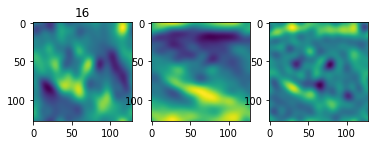

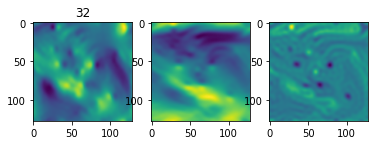

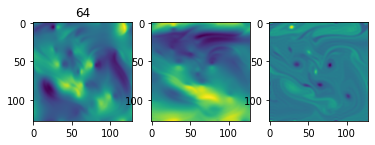

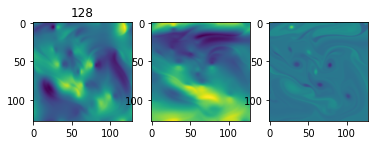

here
(1, 128, 128, 3)
(1, 128, 128, 3)


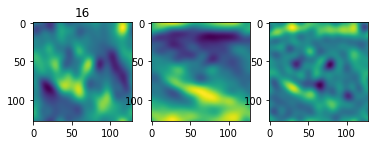

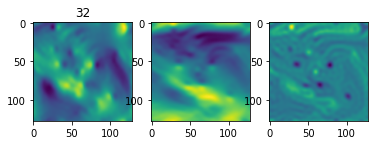

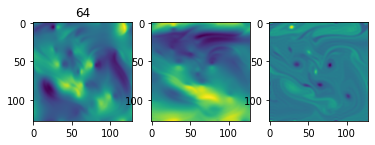

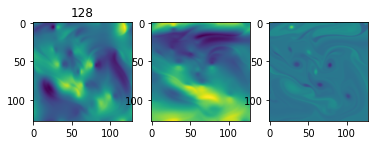

torch.Size([16384, 3]) torch.Size([16384, 3]) torch.Size([128, 128]) torch.Size([1, 128, 128, 3]) torch.Size([1, 128, 128, 3])
0.0006832738423966522
[0.         0.03333333]


In [5]:
# load dataset for TRAIN
dataset_name = 'Synth2D'
dm_train = TurboFlowDataModule(
    dataset=dataset_name, 
    data_dir=data_dir,
    time_idx=time_idxs,
    add_vorticity=add_vorticity,

    train_batch_size=batch_size['train'],
    val_batch_size=batch_size['val'],
    test_batch_size=batch_size['test'],

    train_downsampling_space=dx['train'],
    val_downsampling_space=dx['val'],
    test_downsampling_space=dx['test'],

    train_downsampling_time=dt['train'],
    val_downsampling_time=dt['val'],
    test_downsampling_time=dt['test'],

    train_shuffle=True,
    val_shuffle=False,
    test_shuffle=False,
    num_workers=8)

dm_train.setup(stage='fit')

# datasets = [dm_train.train_dataset, dm_train.val_dataset]
datasets = [dm_train.train_dataset]
for dataset in datasets:
    X, y, extra = dataset[:]
#     print(X.min(dim=0), X.max(dim=0))
    print(X.shape, y.shape, dataset.img_shape, dataset.vars_shape_img, dataset.fields_shape_img)
    print(dataset.diffusion)
    print(dataset.ax_t)

here
(2, 512, 512, 3)
(2, 512, 512, 3)


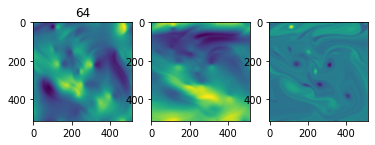

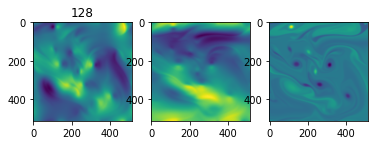

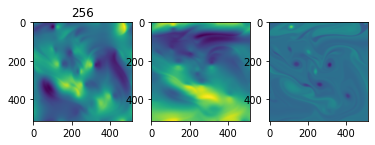

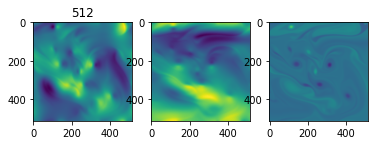

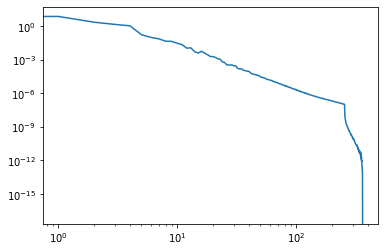

In [6]:
dm_train.setup(stage='test')

dataset = dm_train.test_dataset

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

txy, uv, uv_mid = dataset[:]

TXY = txy.reshape(*vshape)
UVW = uv.reshape(*fshape)

Ek, k = phy.energy_spectrum(UVW[...,:2])

plt.loglog(k, Ek)
plt.show()

path_to_spec = Path(f'../recipes/moMFN/{data_name}_spec_512.tch')
torch.save(Ek, path_to_spec)
Ek = torch.load(path_to_spec)

In [7]:
# dataset = dm_train.train_dataset

# vshape = dataset.vars_shape_img
# fshape = dataset.fields_shape_img

# txy, uv, uv_mid = dataset[:]

# TXY = txy.reshape(*vshape).numpy()
# UV = uv.reshape(*fshape).numpy()
# XY = TXY[0,:,:,1:]

In [8]:
# dataset = dm_train.train_dataset

# vshape = dataset.vars_shape_img
# fshape = dataset.fields_shape_img

# txy, uv, uv_mid = dataset[:]

# TXY = txy.reshape(*vshape).numpy()
# UV = uv.reshape(*fshape).numpy()
# XY = TXY[0,:,:,1:]

# plt.figure(figsize=(20,4))
# plt.subplot(141)
# plt.imshow(TXY[0,:,:,1])
# plt.colorbar()
# plt.subplot(142)
# plt.imshow(TXY[0,:,:,2])
# plt.colorbar()
# plt.subplot(143)
# plt.imshow(UV[0,:,:,0])
# plt.colorbar()
# plt.subplot(144)
# plt.imshow(UV[0,:,:,1])
# plt.colorbar()
# plt.show()

# UV1 = UV[0,:,:,:]
# UV2 = UV[1,:,:,:]
# dt = TXY[1,0,0,0] - TXY[0,0,0,0]
# print(dt)

# D1 = phy.compute_divergence(XY, UV1)
# D2 = phy.compute_divergence(XY, UV2)

# plt.figure(figsize=(10,4))
# plt.subplot(121)
# plt.imshow(D1)
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(D2)
# plt.colorbar()
# plt.show()

# W1 = phy.compute_vorticity(XY, UV1)
# W2 = phy.compute_vorticity(XY, UV2)

# plt.figure(figsize=(10,4))
# plt.subplot(121)
# plt.imshow(W1)
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(W2)
# plt.colorbar()
# plt.show()

# W_t = (W2 - W1)/dt
# plt.imshow(W_t)
# plt.colorbar()
# plt.show()

# [W_x, W_y] = phy.my_grad([W1],[XY[:,0,0], XY[0,:,1]], indexing='ij')[0]

# W_a = W_x * UV1[:,:,0] + W_y * UV1[:,:,1]

# plt.imshow(W_a)
# plt.colorbar()
# plt.show()

# plt.imshow(W_t + W_a)
# plt.colorbar()
# plt.show()

In [14]:
str_time = len(time_idxs) if not time_idxs is None else 'all'
exp_suffix = f'{data_name}_{exp_name}_{str_time}x32x32'
print(exp_suffix)

hparams = {
    'name': exp_name,
    'mlp_layers_num': 4,
    'mlp_layers_dim': 128, 
    'do_divfree': False,
    'pde_diff': dm_train.train_dataset.diffusion,
    'lam_sdiv': 1e-2,    
    'lam_pde' : 1e-2,
    'lam_wrt' : 1e-2,
    'lam_weight': 0,  # L2 reg on the NN's weights
}

Synth2D_0003_moMFN_2x32x32


## Pre-Train: one layer at the time

In [ ]:
from turboflow.models.phyrff import plBACON

hparams['mode'] = 'pre_train'

model = plBACON(**vars(Namespace(**hparams)))

its = [40,  # train res/8 - 1st layer
       40,  # train res/4 - 2nd layer
       40, # train res/2 - 3rd layer
       40  # train res/1 - 4th layes
]
its = np.cumsum(its).tolist()
model.its = its

path_to_spec = Path(f'../recipes/moMFN/{data_name}_spec_512.tch')
model.Ek_tgt = torch.load(path_to_spec)
monitor = 'val/loss/res_s1'
early_stop_callback = EarlyStopping(
    monitor=monitor,
    patience=10,
    min_delta=1e-5)
checkpoint_callback = ModelCheckpoint(
    monitor=monitor,
    dirpath= mdl_dir,
    filename="%s-%s-{epoch:02d}-{val_loss:.5f}" % (exp_suffix, model.mode),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1,
                  max_epochs=model.its[-1],
                  log_every_n_steps=5,
                  check_val_every_n_epoch=10, 
                  callbacks=[early_stop_callback, checkpoint_callback])

trainer.fit(model, dm_train)
pre_train_best_model_path = checkpoint_callback.best_model_path
pre_train_best_model_score = checkpoint_callback.best_model_score

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /home/dicarlo_d/Documents/Code/TurboSuperResultion/recipes/moMFN/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mfn  | ResMFN | 90.0 K
--------------------------------
90.0 K    Trainable params
0         Non-trainable params
90.0

PRE TRAIN


Validation sanity check: 0it [00:00, ?it/s]

Trianing 1st layer - epoch 0


Global seed set to 666


Training: -1it [00:00, ?it/s]

Trianing 1st layer - epoch 0


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
print('Pre-train best model path:')
print(pre_train_best_model_path)

Pre-train best model path:
/home/dicarlo_d/Documents/Code/TurboSuperResultion/recipes/moMFN/models/Synth2D_0003_moMFN_2x32x32-pre_train-epoch=159-val_loss=0.00000-v1.ckpt


## Fine Tuning: all layers

In [11]:
from turboflow.models.phyrff import plBACON
models_dir = '../recipes/moMFN/models/'
pre_train_best_model_name = 'Synth2D_0003_moMFN_2x32x32-pre_train-epoch=159-val_loss=0.00000.ckpt'
best_model_path = models_dir + pre_train_best_model_name
print('Loading from', best_model_path.split('/')[-1])


model = plBACON.load_from_checkpoint(best_model_path, 
                                     mode='fine_tune',
                                     lam_pde=1e-2,
                                     lam_sdiv=1e-2,
                                     lam_weight=1e-5)

path_to_spec = Path(f'../recipes/moMFN/{data_name}_spec_512.tch')
model.Ek_tgt = torch.load(path_to_spec)

monitor = 'val/loss/res_s1'
early_stop_callback = EarlyStopping(monitor=monitor, patience=10, min_delta=1e-5)
checkpoint_callback = ModelCheckpoint(
    monitor=monitor,
    dirpath= mdl_dir,
    filename="%s-%s-{epoch:02d}-{val_loss:.5f}" % (exp_suffix, model.mode),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1, max_epochs=500, log_every_n_steps=5,check_val_every_n_epoch=10, 
                  callbacks=[early_stop_callback, checkpoint_callback])

trainer.fit(model, dm_train)
fine_tune_best_model_path = checkpoint_callback.best_model_path
fine_tune_best_model_score = checkpoint_callback.best_model_score

Loading from Synth2D_0003_moMFN_2x32x32-pre_train-epoch=159-val_loss=0.00000.ckpt


RuntimeError: Error(s) in loading state_dict for plBACON:
	Missing key(s) in state_dict: "mfn.g0.mu", "mfn.g0.gamma", "mfn.g1.mu", "mfn.g1.gamma", "mfn.g2.mu", "mfn.g2.gamma", "mfn.g3.mu", "mfn.g3.gamma", "mfn.g4.mu", "mfn.g4.gamma", "mfn.g5.mu", "mfn.g5.gamma". 

In [ ]:
print('Fine-tune best model path:')
print(fine_tune_best_model_path)

## PDE Tuning: all layers

In [ ]:
from turboflow.models.phyrff import plBACON
best_model_path='/home/dicarlo_d/Documents/Code/TurboSuperResultion/recipes/moMFN/models/Synth2D_0001_moMFN_30x32x32-fine_tune-epoch=289-val_loss=0.00000.ckpt'
print('Loading from', best_model_path.split('/')[-1])
mode = 'pde_tune'
model = plBACON.load_from_checkpoint(best_model_path, 
                                     mode=mode, 
                                     lam_pde=1e-2,
                                     lam_sdiv=1e-2,
                                     lam_weight=1e-5,
                                    )

path_to_spec = Path(f'../recipes/moMFN/{data_name}_spec_512.tch')
model.Ek_tgt = torch.load(path_to_spec)

model.milestones = [100, 150, 200]

monitor = 'val/loss/tot'
early_stop_callback = EarlyStopping(monitor=monitor, patience=3, min_delta=1e-4)
checkpoint_callback = ModelCheckpoint(
    monitor=monitor,
    dirpath= mdl_dir,
    filename="%s-%s-{epoch:02d}-{val_loss:.5f}" % (exp_suffix, model.mode),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1, max_epochs=200, log_every_n_steps=5,check_val_every_n_epoch=10, 
                  callbacks=[early_stop_callback, checkpoint_callback])

trainer.fit(model, dm_train)
pde_tune_best_model_path = checkpoint_callback.best_model_path
pde_tune_best_model_score = checkpoint_callback.best_model_score

In [ ]:
print(pde_tune_best_model_path)
print(pde_tune_best_model_score)

In [ ]:
dataset = dm_train.val_dataset
xy, uv, extra = dataset[:]
fshape = dataset.fields_shape_img
vshape = dataset.vars_shape_img

xy.requires_grad_(True)
uv_pred = model.mfn(xy)[0]

from turboflow.utils import torch_utils as tch

u, v = torch.split(uv_pred, 1, -1)
print(u.shape)

du = tch.diff(u, xy)
u_t, u_x, u_y = du.split(1, -1)

dv = tch.diff(v, xy)
v_t, v_x, v_y = dv.split(1, -1)

plt.imshow(u.detach().numpy().reshape(*fshape[:3])[0,:,:])
plt.show()
plt.imshow(u_x.detach().numpy().reshape(*fshape[:3])[0,:,:])
plt.show()

u_x_diff = np.diff(u.detach().numpy().reshape(*fshape[:3])[0,32,:])

plt.plot(u.detach().numpy().reshape(*fshape[:3])[0,32,:])
plt.plot(u_x.detach().numpy().reshape(*fshape[:3])[0,32,:])
plt.plot(u_x_diff)
plt.show()

In [ ]:
dw = tch.diff(w, xy)
w_t, w_x, w_y = dw.split(1, -1)
ddw = tch.diff(dw, xy)
w_tt, w_xx, w_yy = ddw.split(1, -1)

# spatial change of vorticity / unit volume (u dot Nabla)w
w_spatial = u*w_x + v*w_y
# diffusion of vorticity / univ volume (nu Laplacian w)
diffusion = 0 # 1/self.Re
w_diffusion = diffusion*(w_xx + w_yy)

In [ ]:
plt.imshow(w_spatial.detach().numpy().reshape(*fshape[:3])[1,:,:])

In [ ]:
plt.imshow(w_t.detach().numpy().reshape(*fshape[:3])[1,:,:])

In [ ]:
plt.imshow(torch.abs(w_t + w_spatial).detach().numpy().reshape(*fshape[:3])[1,:,:])
plt.colorbar()

In [ ]:
from turboflow.utils import phy_utils as phy

In [ ]:
t = 0

UV = uv.detach().numpy().reshape(*fshape)
XY = xy.detach().numpy().reshape(*vshape)
print(UV.shape)
print(XY.shape)

plt.figure(figsize=(15,4))
plt.subplot(151)
plt.imshow(XY[t,:,:,0])
plt.subplot(152)
plt.imshow(XY[t,:,:,1])
plt.subplot(153)
plt.imshow(XY[t,:,:,2])
plt.subplot(154)
plt.imshow(UV[t,:,:,0])
plt.subplot(155)
plt.imshow(UV[t,:,:,1])
plt.tight_layout()
plt.show()

[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])

plt.figure(figsize=(12,5))
plt.subplot(141)
plt.imshow(Udx)
plt.subplot(142)
plt.imshow(Udy)
plt.subplot(143)
plt.imshow(Vdx)
plt.subplot(144)
plt.imshow(Vdy)
plt.tight_layout()
plt.show()

W = Vdx - Udy

plt.figure(figsize=(5,5))
plt.imshow(W)
plt.show()

In [ ]:
t=0
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W0 = Vdx - Udy
t=1
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W1 = Vdx - Udy
t=2
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W2 = Vdx - Udy

Wdt = (W1-W0)/4 + (W2-W1)/4
plt.imshow(Wdt)
plt.colorbar()
plt.show()

In [ ]:
t=1
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W1 = Vdx - Udy

[[Wdx, Wdy]] = phy.my_grad([W1], [XY[t,:,0,1], XY[t,0,:,2]])
Wspat = UV[t,:,:,0]*Wdx + UV[t,:,:,1]*Wdy
plt.imshow(Wspat)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(Wdt/np.linalg.norm(Wdt) + Wspat/np.linalg.norm(Wspat))
plt.colorbar()